## Vision Transformer (ViT) model 2D

In [3]:
import numpy as np
import keras
import tensorflow as tf
import keras.layers as layers

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 45s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-08-08 16:39:32.204790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


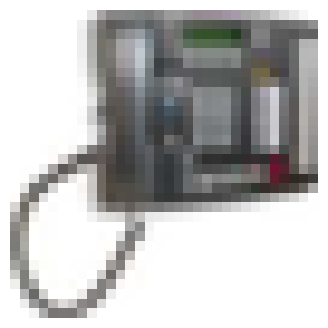

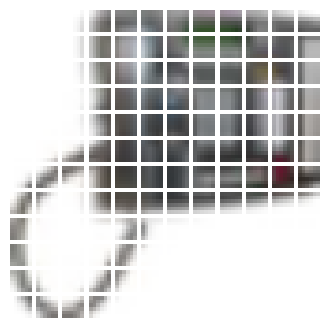

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [13]:
vit_model = create_vit_classifier()
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

## Vision Transformer (ViT) model 3D

In [4]:
import numpy as np
import keras
import tensorflow as tf
import keras.layers as layers

In [2]:
base_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_truth/x7575y7575z5050_trans/s1_test_dis"
X_path = f"{base_dir}/100x100x100_static_s1testdis_X_val.npy"
Y_path = f"{base_dir}/100x100x100_static_s1testdis_Y_val.npy"
length_path = f"{base_dir}/100x100x100_static_s1testdis_length_val.npy"

X_test = np.load(X_path)
Y_test = np.load(Y_path)
length_test = np.load(length_path)

In [3]:
import Functions.MyCrop as MyCrop
import importlib

importlib.reload(MyCrop)

crop_layers = np.asarray([[14, 14], [14, 14], [26, 26]])

X_test_crop, Y_test_crop, length_test_crop = MyCrop.crop_outside_layers(X_test, Y_test, length_test, crop_layers, keep_blank=False)

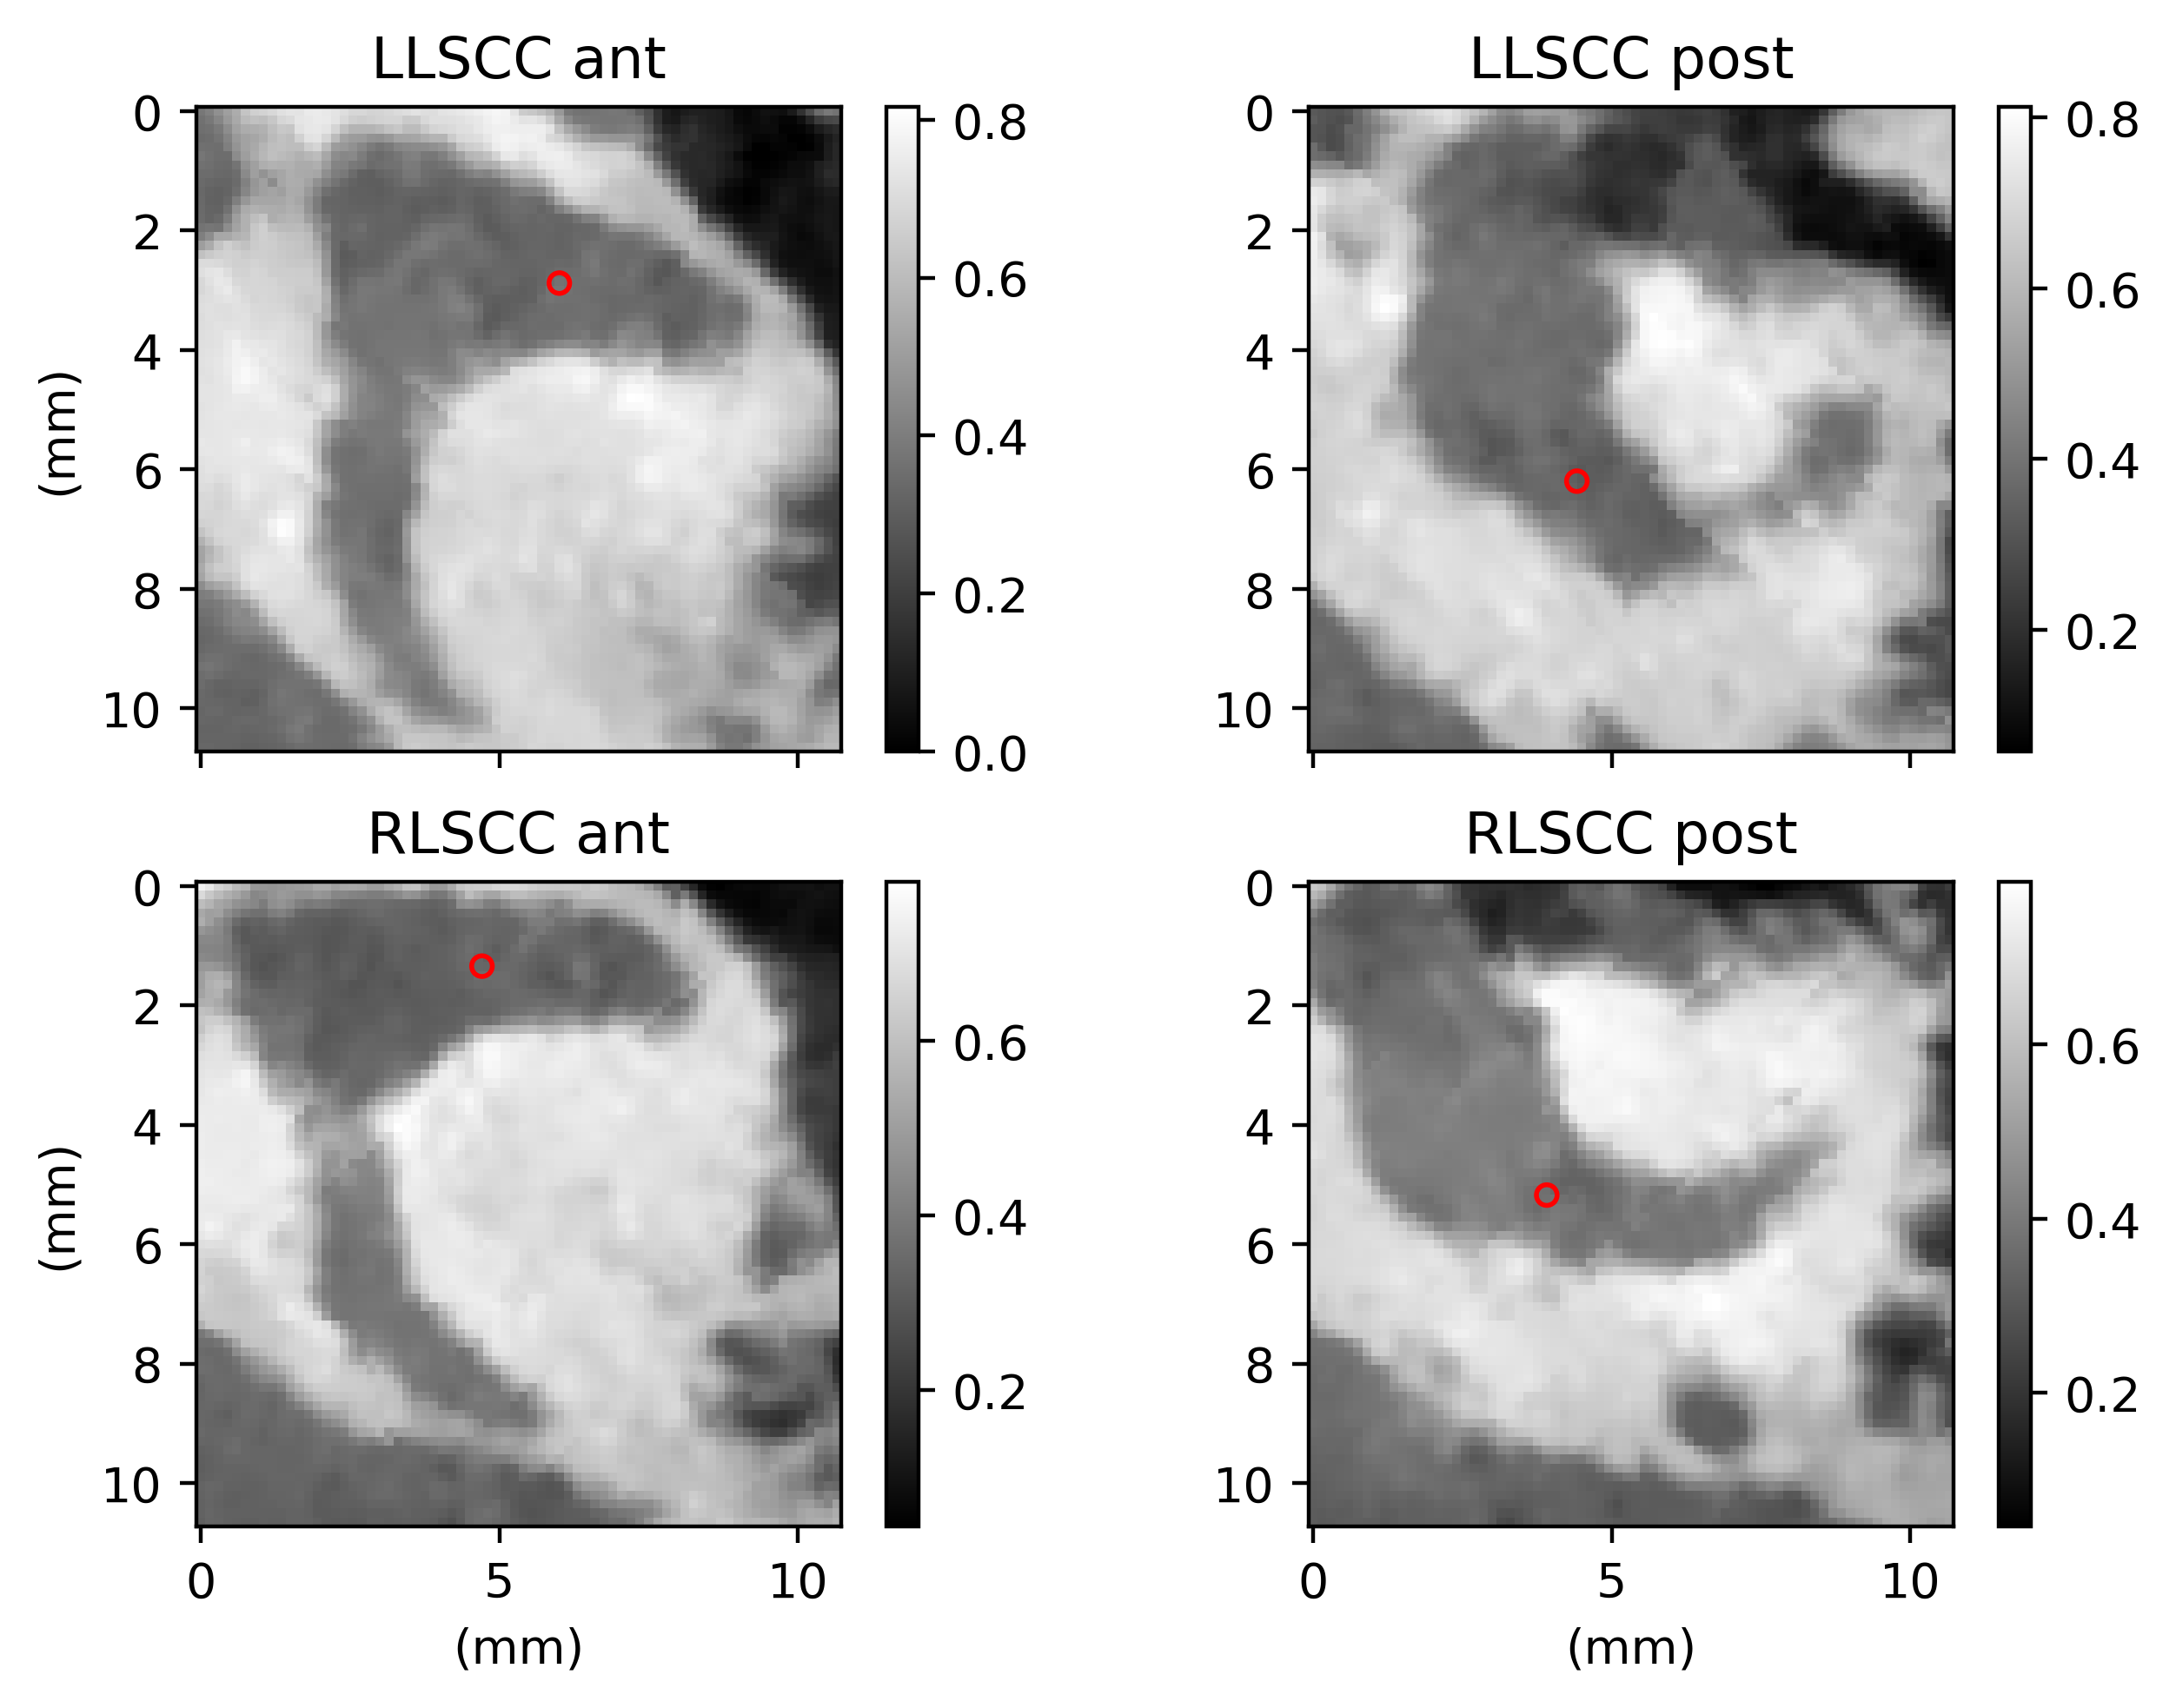

In [4]:
import Functions.Visualization as Visualization

check_id = 6
pixel_space = [0.15, 0.15, 0.15]

Visualization.show_two_landmarks(X_test_crop[check_id, :, :, :, 0], Y_test_crop[check_id], X_test_crop[check_id+1, :, :, :, 0], Y_test_crop[check_id+1], pixel_space)

In [1]:
# learning_rate = 0.001
# weight_decay = 0.0001
# batch_size = 256
# num_epochs = 100
image_size = (72, 72, 48)
patch_size = (6, 6, 4)
num_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1]) * (image_size[2] // patch_size[2])
projection_dim = 256
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [2]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [5]:
class Patches3D(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.extract_volume_patches(
            input=images,
            ksizes=[1, self.patch_size[0], self.patch_size[1], self.patch_size[2], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], self.patch_size[2], 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(-0.5, 71.5, 71.5, -0.5)

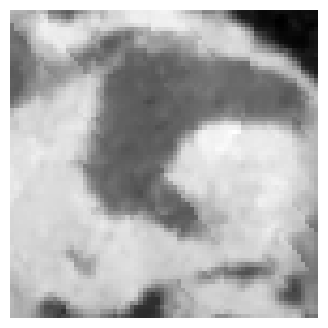

In [36]:
import matplotlib.pyplot as plt

idx = np.random.choice(range(X_test_crop.shape[0]))
sli_idx = (Y_test_crop[idx, 0, 2]-1).astype('int')

plt.figure(figsize=(4, 4))
volume = X_test_crop[idx]
plt.imshow(volume[:,:,sli_idx, :])
plt.axis("off")

In [8]:
volumes = X_test_crop[0:2]
patches = Patches3D(patch_size)(volumes)

2023-08-15 13:45:28.986576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print(Y_test_crop[0:2])

[[[42. 22. 24.]
  [33. 43.  9.]]

 [[38. 22. 29.]
  [31. 46. 14.]]]


In [291]:
print(f"Image size: {image_size}")
print(f"Patch size: {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: (72, 72, 48)
Patch size: (6, 6, 4)
Patches per image: 12
Elements per patch: 144


In [19]:
patches_sli = patches[:, :, :, 5, :]
patches_sli = np.reshape(patches_sli, (2, 12, 12, 6, 6, 4))
patches_one_sli = patches_sli[:, :, :, :, :, 3]
patches_show = tf.reshape(patches_one_sli, (2, 144, 36))

print(np.max(patches_show[0]))
print(np.min(patches_show[0]))

0.8124191
0.017141009


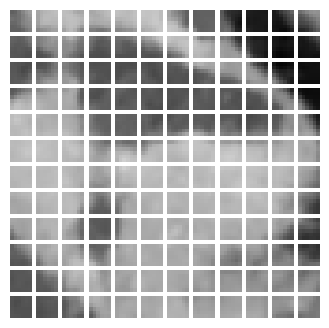

In [20]:
n = 12
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches_show[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (6, 6, 1))
    plt.imshow(patch_img.numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis("off")

In [6]:
class PatchEncoder3D(layers.Layer):
    def __init__(self, num_patches, projection_dim, if_project):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.if_project = if_project
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        if self.if_project:
            encoded = self.projection(patch) + self.position_embedding(positions)
        else:
            encoded = patch + self.position_embedding(positions)
        return encoded

In [30]:
class ConvStem(layers.Layer):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.conv_layers = keras.Sequential(
            [
                layers.Conv3D(kernel_size=3, strides=2, filters=48, padding="same"),
                layers.Conv3D(kernel_size=3, strides=2, filters=96, padding="same"),
                layers.Conv3D(kernel_size=3, strides=2, filters=192, padding="same"),
                layers.Conv3D(kernel_size=3, strides=1, filters=384, padding="same"),
                layers.Conv3D(kernel_size=1, strides=1, filters=self.dim, padding="same")
            ]
        )
        # self.conv_0 = layers.Conv3D(kernel_size=3, strides=2, filters=48, padding="same")
        # self.conv_1 = layers.Conv3D(kernel_size=3, strides=2, filters=96, padding="same")
        # self.conv_2 = layers.Conv3D(kernel_size=3, strides=2, filters=192, padding="same")
        # self.conv_3 = layers.Conv3D(kernel_size=3, strides=2, filters=384, padding="same")

    def call(self, images):
        batch_size = tf.shape(images)[0]
        conv_x = self.conv_layers(images)

        print(conv_x.shape)
        patch_size = conv_x.shape[1] * conv_x.shape[2] * conv_x.shape[3]

        patches = tf.reshape(conv_x, [batch_size, patch_size, self.dim])

        return patches

In [10]:
if_proj = False

In [31]:
def create_vit3D_regression(volume_shape, points_num):
    inputs = layers.Input(shape=volume_shape)
    # Create patches.
    # patches = Patches3D(patch_size)(inputs)
    patches = ConvStem(projection_dim)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder3D(486, projection_dim, if_proj)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # representation = layers.Flatten()(representation)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    # model = keras.Model(inputs=inputs, outputs=logits)
    # Regression ouputs
    reg = layers.Dense(units=points_num * 3, )(features)
    reg = layers.Reshape((points_num, 3))(reg)
    model = keras.Model(inputs=inputs, outputs=reg)
    return model

In [32]:
input_shape_3D = (72, 72, 48, 1)
model_vit3D = create_vit3D_regression(input_shape_3D, 1)
model_vit3D.summary()

(None, 9, 9, 6, 256)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 72, 72, 48,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv_stem_8 (ConvStem)         (None, 486, 256)     2713312     ['input_9[0][0]']                
                                                                                                  
 patch_encoder3d_7 (PatchEncode  (None, 486, 256)    124416      ['conv_stem_8[0][0]']            
 r3D)                                                                                             
                                                                       